# BioBERT-based model to classify biomedical QA pairs into yes/no/maybe.

Two-stage pipeline:
  1. Fine-tune BioBERT on labeled + (weighted) artificial data.
  2. Evaluate model.

## Importing Dataset

In [ ]:
from datasets import load_dataset

# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')

In [ ]:
# Convert the datasets to pandas DataFrames for easier manipulation
import pandas as pd

df_labeled_original = pd.DataFrame(dataset_labeled['train'])
df_unlabeled_original = pd.DataFrame(dataset_unlabeled['train'])
df_artificial_original = pd.DataFrame(dataset_artificial['train'])

In [ ]:
# Make a copy of the original datasets to work on
df_labeled = df_labeled_original.copy()
df_unlabeled = df_unlabeled_original.copy()
df_artificial = df_artificial_original.copy()

## Preprocessing

In [ ]:
df_labeled_clean = df_labeled[df_labeled['final_decision'] != "maybe"]

label_map = {'yes': 0, 'no': 1}
df_labeled['label'] = df_labeled['final_decision'].map(label_map)
df_artificial['label'] = df_artificial['final_decision'].map(label_map)

In [ ]:
df_labeled_final = df_labeled[['question','long_answer', 'label']]
df_artificial_final = df_artificial[['question','long_answer', 'label']]

In [ ]:
# Check class distribution
print(df_labeled_final['label'].value_counts())
print(df_artificial_final['label'].value_counts())

label
0    552
1    338
Name: count, dtype: int64
label
0    196144
1     15125
Name: count, dtype: int64


In [ ]:
# Balance Artificial Dataset (Downsampling)
df_artificial_final = df_artificial_final.groupby('label').sample(n=min(df_artificial_final['label'].value_counts()), random_state=42)
# Shuffle the dataset
df_artificial_final = df_artificial_final.sample(frac=1, random_state=42)
print(df_artificial_final['label'].value_counts())

label
1    15125
0    15125
Name: count, dtype: int64


In [ ]:
len(df_artificial_final)

30250

In [ ]:
df_train = df_artificial_final
df_train.head()

,question,long_answer,label
117741,Are common genetic variants in the microRNA bi...,The common genetic variants in miRNA biogenesi...,1
164514,Do y-SNPs indicate hybridisation between Europ...,The model of a rapid introduction of domestic ...,1
178755,Is genetic polymorphisms ofCYP2A6 andCYP2E1 wi...,Our data indicate that neither a relationship ...,1
51724,Does a background infusion of morphine enhance...,PCA with morphine effectively controlled posto...,1
67278,Do neutrophils promote aerogenous spread of lu...,Tumor shedding is induced by neutrophils. It i...,0


In [ ]:
len(df_train['long_answer'].iloc[0])

108

In [ ]:
from sklearn.model_selection import train_test_split

# Split df_train into train and validation
df_train_split, df_val_split = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train['label'])
df_val_split.head()

,question,long_answer,label
210997,Do negative attitudes among short-term stroke ...,Patients' attitudes toward their illness seem ...,0
41086,Do tumor Enhancement and Heterogeneity Are Ass...,Tumor heterogeneity and enhancement on arteria...,0
77354,Are cortisol patterns associated with T cell a...,These data suggest that the hypothalamic-pitui...,0
150082,Does miRNA expression profiling enable risk st...,"In this study, we present the largest NB miRNA...",0
160332,Is use of proton pump inhibitors associated wi...,Use of PPI was associated with anemia in Japan...,0


In [ ]:
df_test = df_labeled_final
df_test.head()

,question,long_answer,label
0,Do mitochondria play a role in remodelling lac...,Results depicted mitochondrial dynamics in viv...,0
1,Landolt C and snellen e acuity: differences in...,"Using the charts described, there was only a s...",1
2,"Syncope during bathing in infants, a pediatric...","""Aquagenic maladies"" could be a pediatric form...",0
3,Are the long-term results of the transanal pul...,Our long-term study showed significantly bette...,1
4,Can tailored interventions increase mammograph...,The effects of the intervention were most pron...,0


## Finetune BioBERT for QA Classification

Tokenize the data

In [ ]:
from transformers import AutoTokenizer
import torch

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

def encode_data(tokenizer, questions, contexts, max_length):
    encoding = tokenizer(
        questions,
        contexts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask'], encoding['token_type_ids']


In [ ]:
questions = df_train_split["question"].tolist()
contexts = df_train_split["long_answer"].tolist()

input_ids, attention_mask, token_type_ids = encode_data(
    tokenizer,
    questions,
    contexts,
    max_length=512
)


In [ ]:
questions_val = df_val_split["question"].tolist()
contexts_val = df_val_split["long_answer"].tolist()

input_ids_val, attention_mask_val, token_type_ids_val = encode_data(
    tokenizer,
    questions_val,
    contexts_val,
    max_length=512
)


Finetuning BioBERT


In [ ]:
# WE USED 3 EPOCHS AND THE BETTER ONE WA THE FIRST, RERUN WAS NEEDED AND TO 

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load the pre-trained model
modelbert = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=2)
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1, #SEE COMMENT
    per_device_train_batch_size=2,  # lower to fit RAM
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # effectively 8 if batch size 2
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",  # Don't save checkpoints to avoid I/O overhead
    metric_for_best_model="eval_loss",
    #greater_is_better=False,
    #load_best_model_at_end=True,
    fp16=True,
)

from datasets import Dataset

data = {
    'input_ids': input_ids.tolist(),
    'attention_mask': attention_mask.tolist(),
    'token_type_ids': token_type_ids.tolist(),
    'labels': df_train_split['label'].tolist()
}

train_ds = Dataset.from_dict(data)

data_val = {
    'input_ids': input_ids_val.tolist(),
    'attention_mask': attention_mask_val.tolist(),
    'token_type_ids': token_type_ids_val.tolist(),
    'labels': df_val_split['label'].tolist()
}

val_ds = Dataset.from_dict(data_val)

# Create the Trainer and start training
trainer = Trainer(
    model=modelbert,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset = val_ds,
)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,0.168400,0.151503


TrainOutput(global_step=3403, training_loss=0.22475948149479036, metrics={'train_runtime': 1387.8065, 'train_samples_per_second': 19.617, 'train_steps_per_second': 2.452, 'total_flos': 7162935371120640.0, 'train_loss': 0.22475948149479036, 'epoch': 0.9999265408065819})

## Testing

In [ ]:
questions_test = df_test["question"].tolist()
contexts_test = df_test["long_answer"].tolist()

input_ids_test, attention_mask_test, token_type_ids_test = encode_data(
    tokenizer,
    questions_test,
    contexts_test,
    max_length=512
)

In [ ]:
from datasets import Dataset

test_data = {
    'input_ids': input_ids_test.tolist(),
    'attention_mask': attention_mask_test.tolist(),
    'token_type_ids': token_type_ids_test.tolist(),
    'labels': df_test['label'].tolist()
}

test_dataset = Dataset.from_dict(test_data)

In [ ]:
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids

Classification Report:
              precision    recall  f1-score   support

         yes       0.97      0.85      0.90       552
          no       0.79      0.96      0.87       338

    accuracy                           0.89       890
   macro avg       0.88      0.90      0.89       890
weighted avg       0.90      0.89      0.89       890



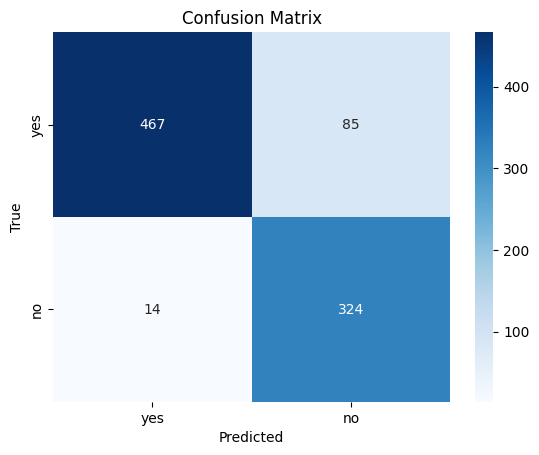

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted class
preds = np.argmax(logits, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(labels, preds, target_names=['yes', 'no']))  # Adjust names if needed

# Confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['yes', 'no'],
            yticklabels=['yes', 'no'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()